# Classification of Radiative Trident Events

### Omar Moreno (Santa Cruz Institute for Particle Physics, University of California, Santa Cruz)

## Introduction

The background expected to dominate the final event sample of the Heavy Photon Search experiment is the process e-W -> e-e-e+W, otherwise known as tridents.  As shown on Figures [], these tridents can be seperated out into two main diagrams: Bethe-Heitler and radiatives.  The kinematics of radiatives are indistinguiable from the A' and, thus, are useful in analyzing the A' signal as

It is then crucial to try to maximize the number of radiative events in the final event samples.  and is used in setting limits in mass-coupling space using using the formula

Although BH background is the dominant (factor of 5) amplitude among the two processes, it's different kinematics can be used to significantly reduce the number of BH.  

This notebook discusses how the classification of radiatives can be improved with the aid of classifiers ... 

In [26]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import numpy as np
import root_numpy as rnp
import matplotlib.pyplot as plt

# Use the Bayesian Methods for Hackers design
plt.style.use('bmh')

## Preprocessing of Signal an Background Events

The HPS experiment maximizes it's acceptance to trident like events by triggering on trident like events.  It is then expected that the final state Trident electron-positron pair will be within the acceptance of both the Ecal and SVT.  This implies that both the electron and positron will leave charge depositions in the SVT which can be used to reconstruct the momentum and vertex of the particle, along with energy depositions in the Ecal used for their energy measurement. Because of the good time resolution of the Ecal, a cluster pair can be easily selected in an event.  The cluster pair can then be matched up to the two electron-positron trident tracks in the event.  

These requirements will be applied at the preprocessing level.  Specifically, the two clusters are required to be within a 1.6 ns window relative to each other while extrapolated tracks are expected to be within 2 mm of the corresponding clusters.  Events passing these cuts are then written out to a flat tuple including the following variables. 

#### Features

In [9]:
# Open a ROOT file and create a record array out of both the preprocessed BH and Rad ntuples
X_rad_rec = rnp.root2array("rad_preprocessed_file.root")
X_bh_rec = rnp.root2array("bh_preprocessed_file.root")

features = rnp.list_branches("rad_preprocessed_file.root")

print '\n'.join(str(feature) for feature in features)

cluster_0_energy
cluster_1_energy
cluster_0_x
cluster_1_x
cluster_0_y
cluster_1_y
track_0_p
track_0_px
track_0_py
track_0_pz
track_0_theta
track_0_phi0
track_0_omega
track_0_d0
track_0_z0
track_1_p
track_1_px
track_1_py
track_1_pz
track_1_theta
track_1_phi0
track_1_omega
track_1_d0
track_1_z0
track_pair_p_sum


#### Preprocessed Distributions

In [12]:
# Convert the data into an array that can be used as an input into scikit-learn
X_rad = rnp.rec2array(X_rad_rec)
X_bh = rnp.rec2array(X_bh_rec)

# Truncate the array containing the Radiative features so it matches that Bethe-Heitler
# array length
X_rad = X_rad[:len(X_bh)]
#print X_rad.shape
#print X_bh.shape

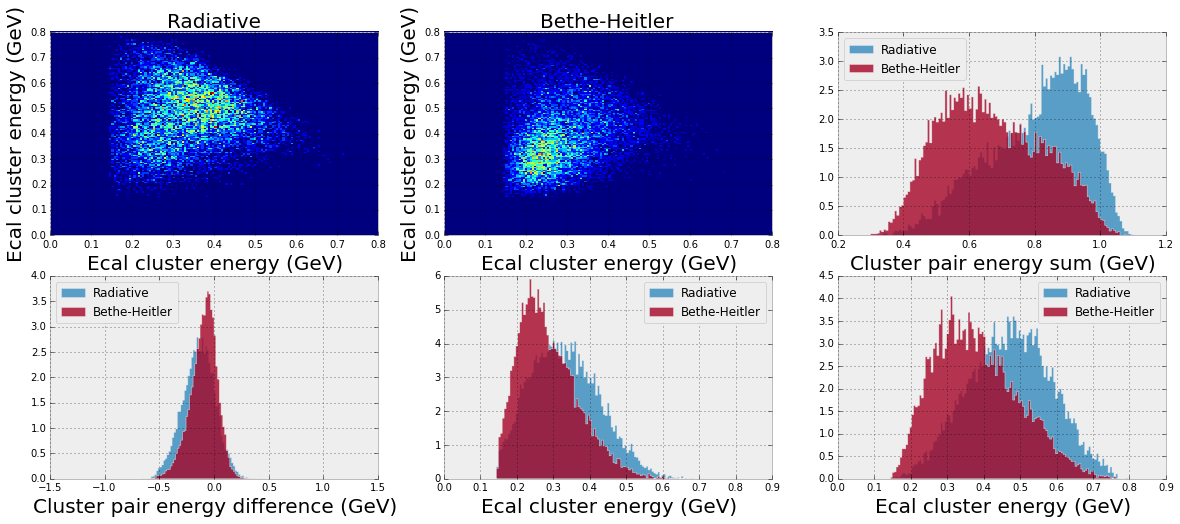

In [46]:
rad_cluster_0_energy = X_rad[:,0]
rad_cluster_1_energy = X_rad[:,1]
bh_cluster_0_energy = X_bh[:,0]
bh_cluster_1_energy = X_bh[:,1]

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

bkg_names = ['Radiative', 'Bethe-Heitler']

ax0.hist2d(rad_cluster_0_energy, rad_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax0.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_title(bkg_names[0], fontsize=20)

ax1.hist2d(bh_cluster_0_energy, bh_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax1.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax1.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)
ax1.set_title(bkg_names[1], fontsize=20)

ax2.hist(rad_cluster_0_energy+rad_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax2.hist(bh_cluster_0_energy+bh_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax2.set_xlabel("Cluster pair energy sum (GeV)", fontsize=20)
ax2.legend(loc=2)

ax3.hist(rad_cluster_0_energy-rad_cluster_1_energy, bins=150, range=(-1.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax3.hist(bh_cluster_0_energy-bh_cluster_1_energy, bins=150, range=(-1.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax3.set_xlabel("Cluster pair energy difference (GeV)", fontsize=20)
ax3.legend(loc=2)

ax4.hist(rad_cluster_0_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax4.hist(bh_cluster_0_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax4.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax4.legend()

ax5.hist(rad_cluster_1_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0] )
ax5.hist(bh_cluster_1_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax5.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax5.legend();

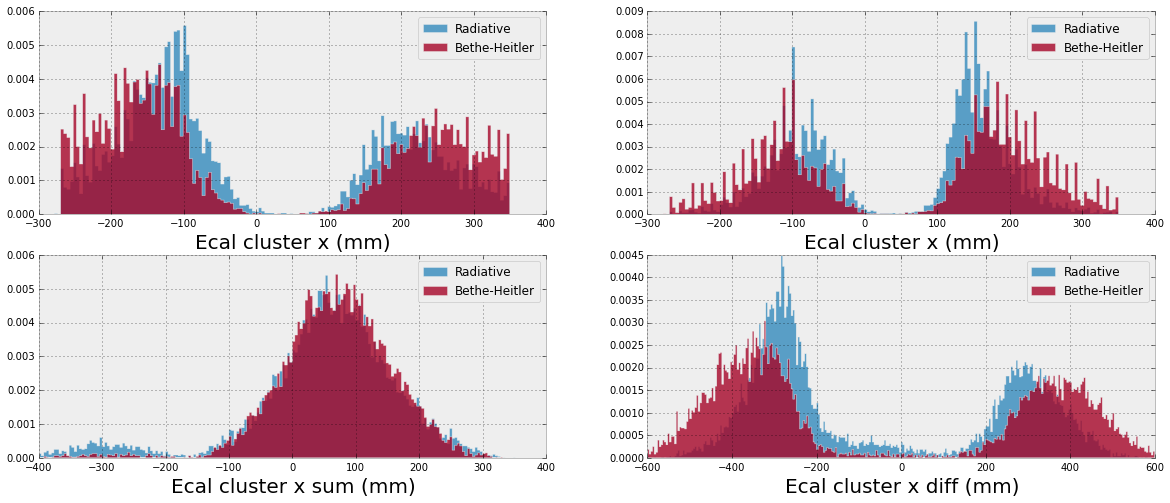

In [44]:
rad_cluster_0_x = X_rad[:,2]
rad_cluster_1_x = X_rad[:,3]
bh_cluster_0_x = X_bh[:,2]
bh_cluster_1_x = X_bh[:,3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

ax0.hist(rad_cluster_0_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax0.hist(bh_cluster_0_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax0.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax0.legend()

ax1.hist(rad_cluster_1_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax1.hist(bh_cluster_1_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax1.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax1.legend()

ax2.hist(rad_cluster_0_x + rad_cluster_1_x, bins=200, range=(-400, 400), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax2.hist(bh_cluster_0_x + bh_cluster_1_x, bins=200, range=(-400, 400), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax2.set_xlabel("Ecal cluster x sum (mm)", fontsize=20)
ax2.legend()

ax3.hist(rad_cluster_0_x - rad_cluster_1_x, bins=300, range=(-600, 600), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax3.hist(bh_cluster_0_x - bh_cluster_1_x, bins=300, range=(-600, 600), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax3.set_xlabel("Ecal cluster x diff (mm)", fontsize=20);
ax3.legend()


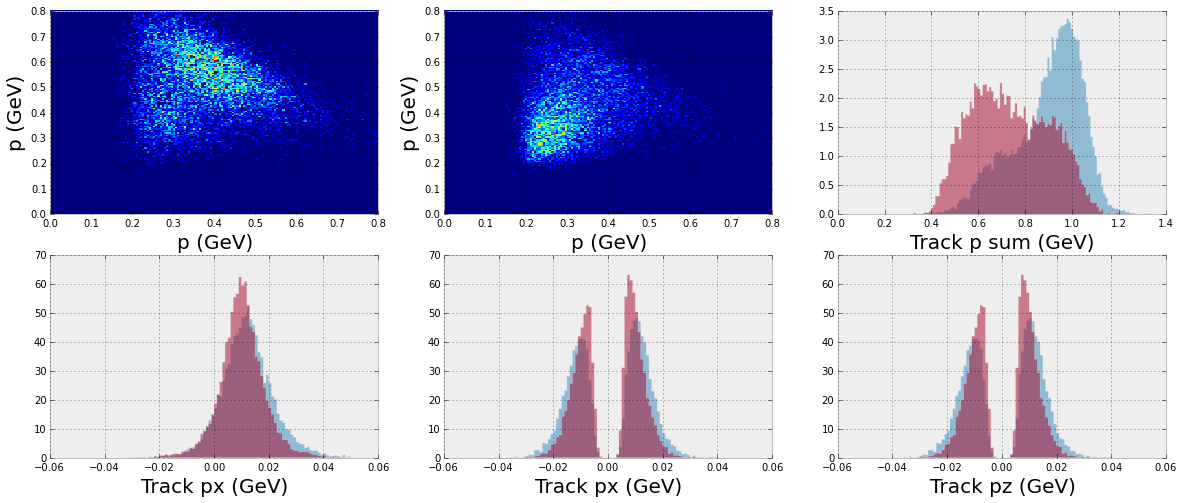

In [48]:
rad_track_0_p = X_rad[:,6]
rad_track_0_px = X_rad[:,7]
rad_track_0_py = X_rad[:,8]
rad_track_0_pz = X_rad[:,9]
rad_track_1_p = X_rad[:,15]
rad_track_1_px = X_rad[:,16]
rad_track_1_py = X_rad[:,17]
rad_track_1_pz = X_rad[:,18]

bh_track_0_p = X_bh[:,6]
bh_track_0_px = X_bh[:,7]
bh_track_0_py = X_bh[:,8]
bh_track_0_pz = X_bh[:,9]
bh_track_1_p = X_bh[:,15]
bh_track_1_px = X_bh[:,16]
bh_track_1_py = X_bh[:,17]
bh_track_1_pz = X_bh[:,18]

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

ax0.hist2d(rad_track_0_p, rad_track_1_p, bins=150, range=[[0, 0.8], [0, 0.8]])
ax0.set_xlabel("p (GeV)", fontsize=20)
ax0.set_ylabel("p (GeV)", fontsize=20)

ax1.hist2d(bh_track_0_p, bh_track_1_p, bins=150, range=[[0, 0.8], [0, 0.8]])
ax1.set_xlabel("p (GeV)", fontsize=20)
ax1.set_ylabel("p (GeV)", fontsize=20)

ax2.hist(rad_track_0_p + rad_track_1_p, bins=150, range=(0.02, 1.4), alpha=0.5, normed=True, histtype="stepfilled")
ax2.hist(bh_track_0_p + bh_track_1_p, bins=150, range=(0.02, 1.4), alpha=0.5, normed=True, histtype="stepfilled")
ax2.set_xlabel("Track p sum (GeV)", fontsize=20)

ax3.hist(rad_track_0_px, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax3.hist(bh_track_0_px, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax3.set_xlabel("Track px (GeV)", fontsize=20)

ax4.hist(rad_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax4.hist(bh_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax4.set_xlabel("Track px (GeV)", fontsize=20)

ax5.hist(rad_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax5.hist(bh_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.5, normed=True, histtype="stepfilled");
ax5.set_xlabel("Track pz (GeV)", fontsize=20)


In [50]:
# Create the targets
y_rad = np.ones(len(X_rad))
y_bh = np.zeros(len(X_bh))

rad_zip = zip(X_rad, y_rad)
bh_zip = zip(X_bh, y_bh)

X_merge = np.concatenate((rad_zip, bh_zip))
np.random.shuffle(X_merge)

X_list, y_list = map(list, zip(*X_merge))

X = np.array(X_list)
print "Shape of X: " + str(X.shape)

y = np.array(y_list)
print "Shape of y: " + str(y.shape)

Shape of X: (24262, 25)
Shape of y: (24262,)


## Using Ensemble Methods to Classify Radiatives

### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

RANDOM_STATE = 123

forest_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in forest_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 200

for label, clf in forest_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

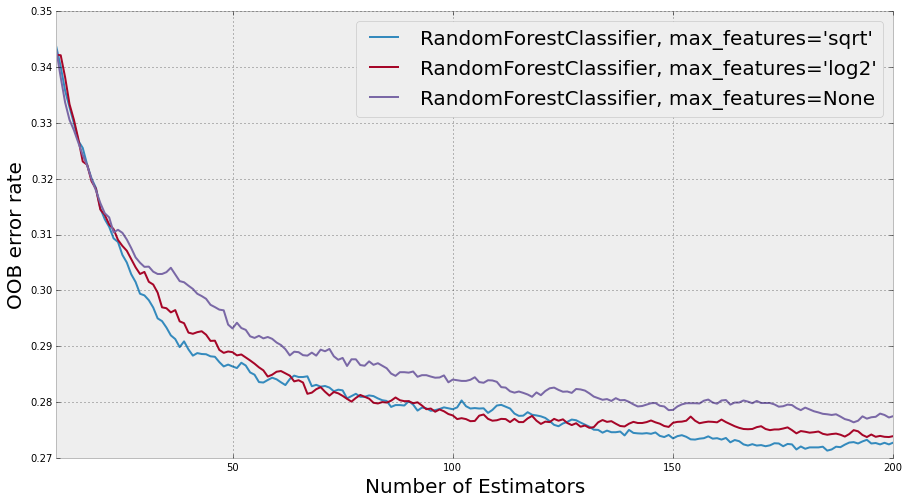

In [70]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ax.plot(xs, ys, label=label)

ax.set_xlim(min_estimators, max_estimators)
ax.set_xlabel("Number of Estimators", fontsize=20)
ax.set_ylabel("OOB error rate", fontsize=20)
ax.legend(loc=1, fontsize=20);

In [8]:
from sklearn import cross_validation
from sklearn import metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

## Decision Tree

In [9]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(max_depth=10)

In [10]:
predictions = tree_clf.fit(X_train, y_train).predict(X_test)

print metrics.classification_report(y_test, predictions, target_names=['radiative', 'Bethe-Heitler'])

               precision    recall  f1-score   support

    radiative       0.70      0.65      0.68      6091
Bethe-Heitler       0.67      0.72      0.69      6040

  avg / total       0.69      0.69      0.69     12131



/home/omoreno/packages/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


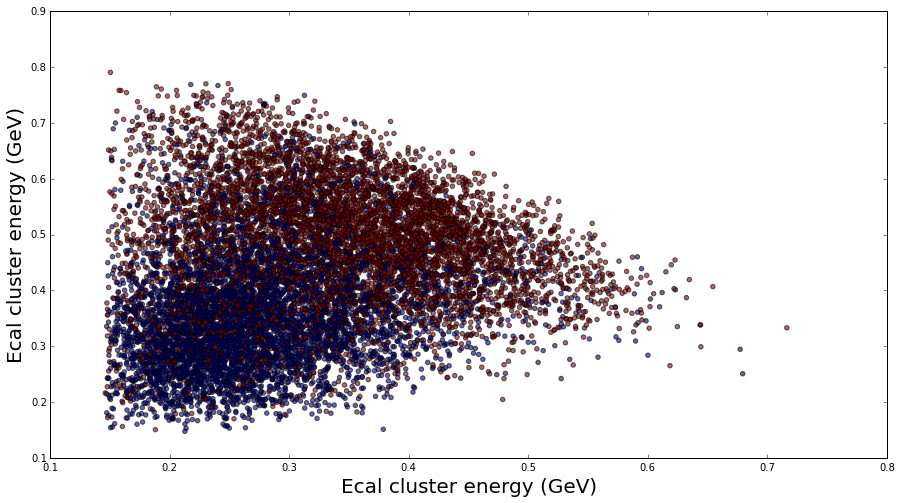

In [11]:
fig, ax0 = plt.subplots(figsize=(15, 8))

ax0.scatter(X_test[:,0], X_test[:,1], c=predictions, alpha=0.6)
ax0.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)

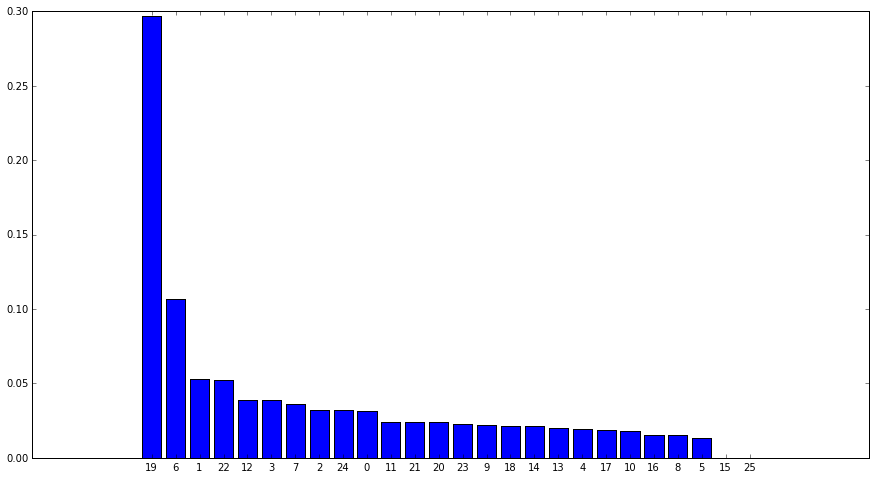

In [12]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
fig, ax0 = plt.subplots(figsize=(15, 8))

ax0.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices);

[[3986 2105]
 [1703 4337]]


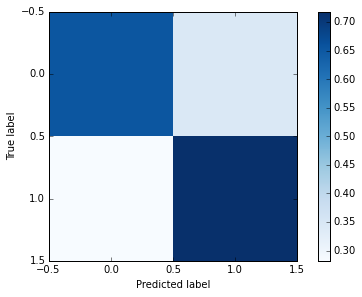

In [13]:
cm = metrics.confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
cmap=plt.cm.Blues
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [15]:
predictions = forest_clf.fit(X_train, y_train).predict(X_test)

print metrics.classification_report(y_test, predictions, target_names=['radiative', 'Bethe-Heitler'])

               precision    recall  f1-score   support

    radiative       0.75      0.69      0.72      6091
Bethe-Heitler       0.71      0.77      0.74      6040

  avg / total       0.73      0.73      0.73     12131



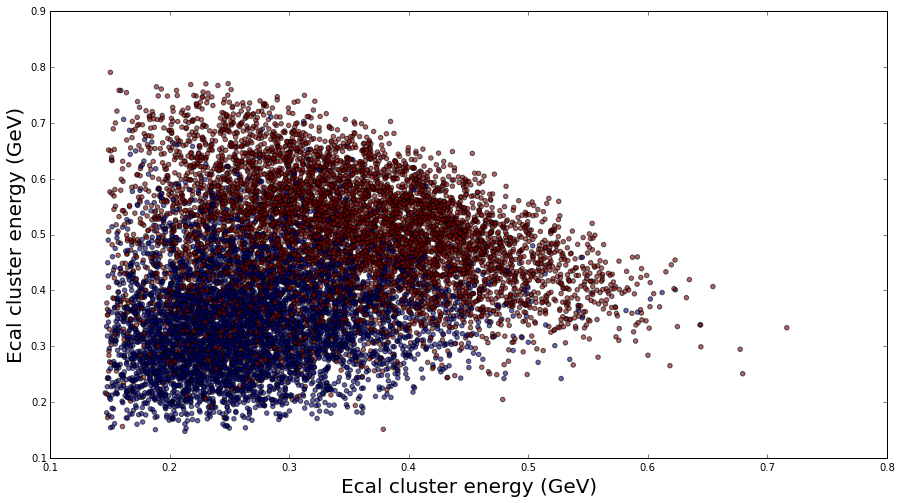

In [16]:
fig, ax0 = plt.subplots(figsize=(15, 8))

ax0.scatter(X_test[:,0], X_test[:,1], c=predictions, alpha=0.6)
ax0.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)

[[4214 1877]
 [1376 4664]]


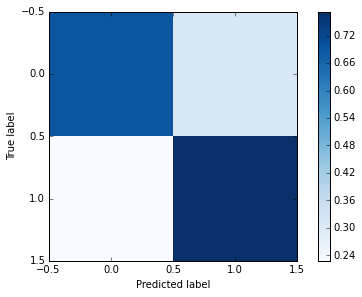

In [17]:
cm = metrics.confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
cmap=plt.cm.Blues
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')